In [1]:
%cd ..

c:\Users\esper\Desktop\injury_forecasting


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from src.plotting import set_plot_style
from src.config import DATA_DIR, FIGURES_DIR
set_plot_style()

In [5]:
from src.aggregation import aggregate_panel, check_panel_balance

In [7]:
import pandas as pd

In [8]:
monthly_complete = pd.read_csv(DATA_DIR / "cleaned" / "cleaned_monthly_panel.csv", parse_dates=['Date'])

In [9]:
from src.features import build_panel_features

X_m, y_m, meta_m = build_panel_features(
    panel_df=monthly_complete,
    target="HospRisk",
    group_col="State",
    date_col="Date",
    freq="MS",
    add_calendar=True,
    add_lags=True,
    add_rolling=True,
    add_ewm=True,
    lags=(1, 2, 3, 6, 12),
    rolling_windows=(3, 6, 12),
    ewm_spans=(3, 6, 12),
    dropna=True,
)

X_m.head(), y_m.head(), meta_m.head()


(   year  month  quarter  month_sin     month_cos  HospRisk_lag1  \
 0  2016      1        1   0.500000  8.660254e-01       0.604047   
 1  2016      2        1   0.866025  5.000000e-01       1.458312   
 2  2016      3        1   1.000000  6.123234e-17       0.854744   
 3  2016      4        2   0.866025 -5.000000e-01       0.854186   
 4  2016      5        2   0.500000 -8.660254e-01       1.052368   
 
    HospRisk_lag2  HospRisk_lag3  HospRisk_lag6  HospRisk_lag12  \
 0       0.907441       1.313065       1.268649        0.714760   
 1       0.604047       0.907441       1.164498        0.765072   
 2       1.458312       0.604047       0.758802        1.123538   
 3       0.854744       1.458312       1.313065        1.070064   
 4       0.854186       0.854744       0.907441        1.168046   
 
    HospRisk_rollmean3  HospRisk_rollmean6  HospRisk_rollmean12  HospRisk_ewm3  \
 0            0.941518            1.002750             0.993696       0.813459   
 1            0.989934

In [11]:
import numpy as np

def yearly_train_ends(meta: pd.DataFrame, date_col: str = "Date") -> list[pd.Timestamp]:
    dates = pd.to_datetime(meta[date_col], errors="raise")
    tmp = pd.DataFrame({"Date": dates})
    tmp["year"] = tmp["Date"].dt.year
    ends = tmp.groupby("year")["Date"].max().sort_values()
    return list(ends.values)

def rolling_origin_masks(
    meta: pd.DataFrame,
    date_col: str,
    train_ends: list[pd.Timestamp],
    test_size: int = 12,
) -> list[dict]:
    dates = pd.to_datetime(meta[date_col], errors="raise")
    unique_dates = pd.Index(np.sort(dates.unique()))

    splits = []
    for te in train_ends:
        te = pd.to_datetime(te)

        train_dates = unique_dates[unique_dates <= te]
        future_dates = unique_dates[unique_dates > te]
        if len(train_dates) == 0 or len(future_dates) == 0:
            continue

        test_dates = future_dates[:test_size]  # truncated if not enough

        train_mask = dates.isin(train_dates)
        test_mask  = dates.isin(test_dates)

        if (train_mask & test_mask).any():
            raise RuntimeError("Overlap detected between train and test.")

        splits.append({
            "train_end": te,
            "test_start": test_dates.min(),
            "test_end": test_dates.max(),
            "n_train_rows": int(train_mask.sum()),
            "n_test_rows": int(test_mask.sum()),
            "n_train_weeks": len(train_dates),
            "n_test_weeks": len(test_dates),
            "train_mask": train_mask,
            "test_mask": test_mask,
        })

    return splits

train_ends = yearly_train_ends(meta_m, date_col="Date")
splits = rolling_origin_masks(meta_m, date_col="Date", train_ends=train_ends, test_size=12)

len(train_ends), len(splits)


(9, 8)

In [12]:
split_calendar = pd.DataFrame([
    {
        "train_end": s["train_end"].date(),
        "test_start": s["test_start"].date(),
        "test_end": s["test_end"].date(),
        "train_weeks": s["n_train_weeks"],
        "test_weeks": s["n_test_weeks"],
        "train_rows": s["n_train_rows"],
        "test_rows": s["n_test_rows"],
    }
    for s in splits
])

split_calendar.head(10)


,train_end,test_start,test_end,train_weeks,test_weeks,train_rows,test_rows
0,2016-12-01,2017-01-01,2017-12-01,12,12,360,360
1,2017-12-01,2018-01-01,2018-12-01,24,12,720,360
2,2018-12-01,2019-01-01,2019-12-01,36,12,1080,360
3,2019-12-01,2020-01-01,2020-12-01,48,12,1440,360
4,2020-12-01,2021-01-01,2021-12-01,60,12,1800,360
5,2021-12-01,2022-01-01,2022-12-01,72,12,2160,360
6,2022-12-01,2023-01-01,2023-12-01,84,12,2520,360
7,2023-12-01,2024-01-01,2024-12-01,96,12,2880,360


In [14]:
# train_end dates to keep
keep_train_ends = {
    pd.Timestamp("2018-12-01"),
    pd.Timestamp("2019-12-01"),
    pd.Timestamp("2020-12-01"),
    pd.Timestamp("2021-12-01"),
    pd.Timestamp("2022-12-01"),
    pd.Timestamp("2023-12-01"),
}

# filter splits
splits_origins = [
    s for s in splits
    if pd.Timestamp(s["train_end"]) in keep_train_ends
]

len(splits_origins), [s["train_end"].date() for s in splits_origins]


(6,
 [datetime.date(2018, 12, 1),
  datetime.date(2019, 12, 1),
  datetime.date(2020, 12, 1),
  datetime.date(2021, 12, 1),
  datetime.date(2022, 12, 1),
  datetime.date(2023, 12, 1)])

In [15]:
from src.models import get_model_configs, instantiate_models
from src.training import fit_global_models

In [18]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, root_mean_squared_error

def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

neg_rmse_scorer = make_scorer(rmse, greater_is_better=False)

perm_rows_m = []  # store per-fold importances


In [19]:
from sklearn.metrics import mean_absolute_error

results_rows_m = []

horizons = [1, 3, 6]

for split in splits_origins:
    train_end = split["train_end"]

    for h in horizons:
        # --------------------------------------------------
        # 1. Direct multi-step target
        # --------------------------------------------------
        y_h = (
            y_m
            .groupby(meta_m["State"], sort=False)
            .shift(-h)
        )

        y_naive = y_m.groupby(meta_m["State"], sort=False).shift(12 - h)
        
        valid_mask = y_h.notna()

        train_mask = split["train_mask"] & valid_mask
        test_mask  = split["test_mask"]  & valid_mask

        valid_mask_naive = valid_mask & (y_naive.notna())
        test_mask_naive = split["test_mask"]  & valid_mask_naive

        X_train = X_m.loc[train_mask]
        y_train = y_h.loc[train_mask]
        meta_train = meta_m.loc[train_mask]

        X_test = X_m.loc[test_mask]
        y_test = y_h.loc[test_mask]
        meta_test = meta_m.loc[test_mask]

        # --------------------------------------------------
        # 2. Instantiate and fit global models
        # --------------------------------------------------
        model_configs = get_model_configs(
            n_samples=len(X_train),
            use_linear=True,
            use_tree=True,
            random_state=0,
            n_jobs=-1,
        )
        models = instantiate_models(model_configs)

        fitted = fit_global_models(
            models=models,
            X_train=X_train,
            y_train=y_train,
        )

        # for baseline, store naive predictions
        tmp_naive = meta_m.loc[test_mask_naive].copy()
        tmp_naive["train_end"] = train_end
        tmp_naive["horizon"] = h
        tmp_naive["model"] = "Seasonal Naive"
        tmp_naive["y_true"] = y_h.loc[test_mask_naive].values
        tmp_naive["y_pred"] = y_naive.loc[test_mask_naive].values
        results_rows_m.append(tmp_naive)
        # --------------------------------------------------
        # 3. Predict and store results (TEST only)
        # --------------------------------------------------
        for model_name, model in fitted.items():
            y_pred = model.predict(X_test)

            tmp = meta_test.copy()
            tmp["train_end"] = train_end
            tmp["horizon"] = h
            tmp["model"] = model_name
            tmp["y_true"] = y_test.values
            tmp["y_pred"] = y_pred

            pi = permutation_importance(
                model,
                X_test,
                y_test,
                scoring=neg_rmse_scorer,
                n_repeats=5,
                random_state=0,
                n_jobs=-1,
            )

            imp = pd.DataFrame({
                "feature": X_test.columns,
                "importance": pi.importances_mean,
                "importance_std": pi.importances_std,
            })
            imp["train_end"] = train_end
            imp["horizon"] = h
            imp["model"] = model_name

            perm_rows_m.append(imp)
            results_rows_m.append(tmp)


In [20]:
results_df_m = pd.concat(results_rows_m, ignore_index=True)

results_df_m.head()



,State,Date,train_end,horizon,model,y_true,y_pred
0,ALABAMA,2019-01-01,2018-12-01,1,Seasonal Naive,1.209190,1.279779
1,ALABAMA,2019-02-01,2018-12-01,1,Seasonal Naive,1.062597,0.933248
2,ALABAMA,2019-03-01,2018-12-01,1,Seasonal Naive,1.541574,1.127949
3,ALABAMA,2019-04-01,2018-12-01,1,Seasonal Naive,1.299764,1.862289
4,ALABAMA,2019-05-01,2018-12-01,1,Seasonal Naive,1.299139,1.366921


In [21]:

results_df_m.groupby(["train_end", "horizon"]).size()




train_end   horizon
2018-12-01  1          2880
            3          2880
            6          2880
2019-12-01  1          2880
            3          2880
            6          2880
2020-12-01  1          2880
            3          2880
            6          2880
2021-12-01  1          2880
            3          2880
            6          2880
2022-12-01  1          2880
            3          2880
            6          2880
2023-12-01  1          2640
            3          2160
            6          1440
dtype: int64

In [22]:
results_df_m[["y_true", "y_pred"]].isna().sum()

y_true    0
y_pred    0
dtype: int64

In [24]:
results_df_m["model"].value_counts()


model
Seasonal Naive    6180
Ridge             6180
Lasso             6180
ElasticNet        6180
PLS               6180
XGBoost           6180
LightGBM          6180
CatBoost          6180
Name: count, dtype: int64

In [86]:
res_df = results_df_m.copy()
res_df["residual"] = res_df["y_true"] - res_df["y_pred"]




In [87]:
h = 1
df_h = res_df[res_df["horizon"] == h]


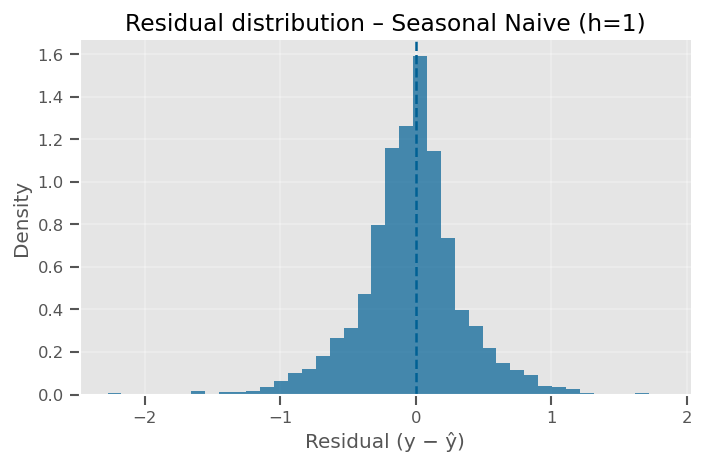

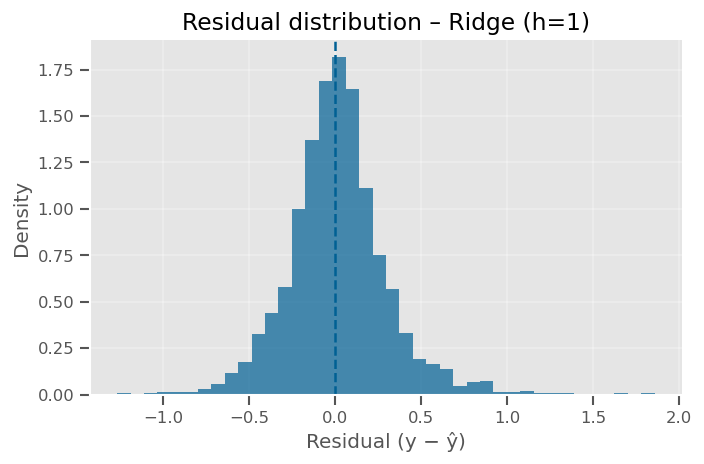

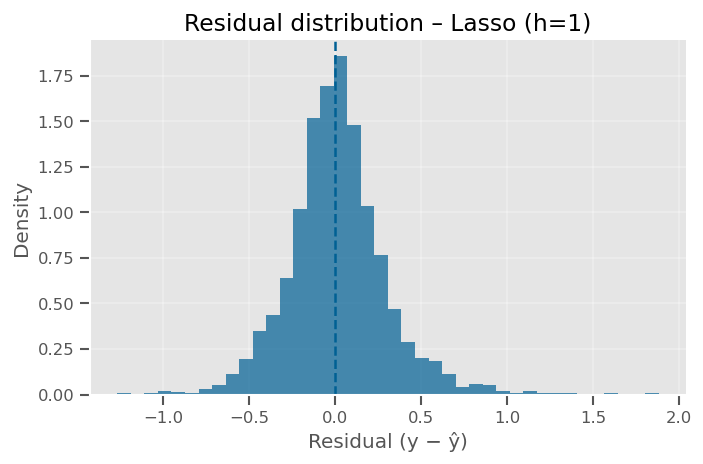

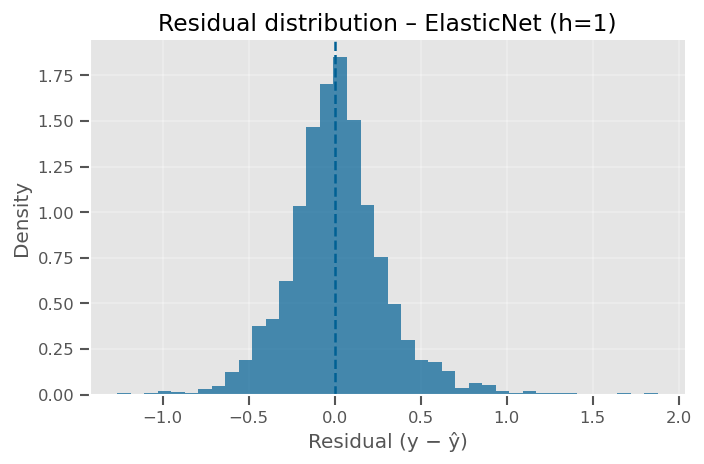

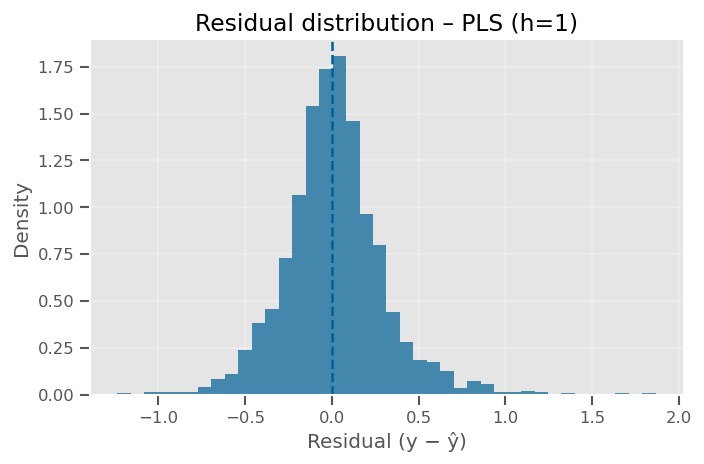

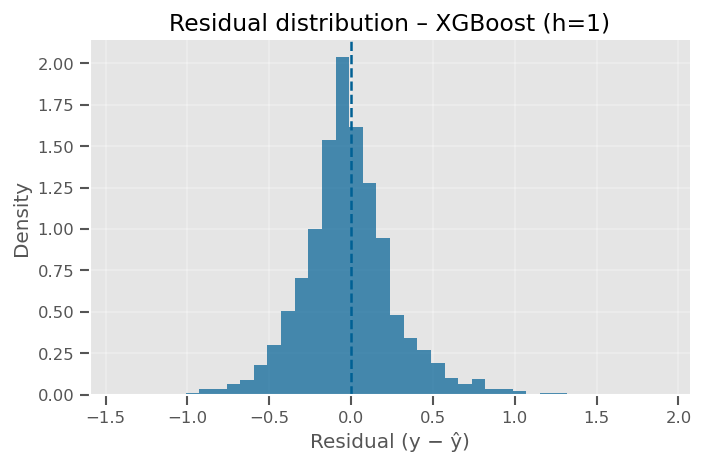

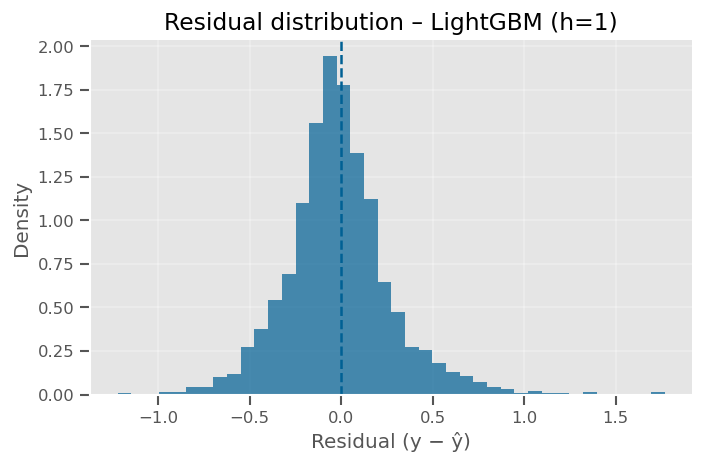

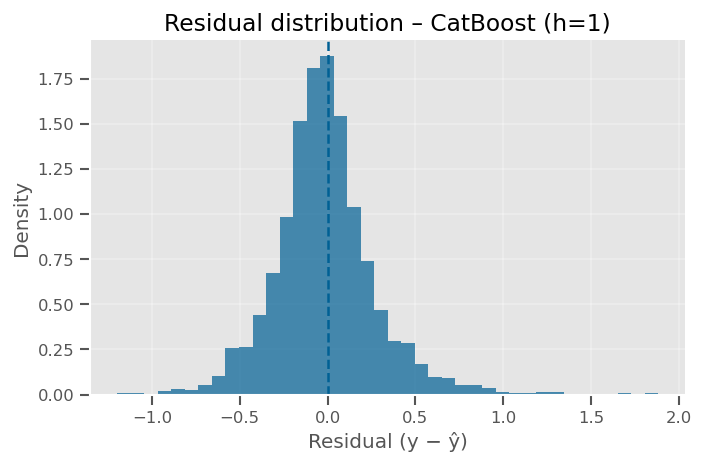

In [88]:
import matplotlib.pyplot as plt

models = df_h["model"].unique()

for model in models:
    r = df_h.loc[df_h["model"] == model, "residual"]

    plt.figure(figsize=(6, 4))
    plt.hist(r, bins=40, density=True, alpha=0.7)
    plt.axvline(0, linestyle="--")
    plt.title(f"Residual distribution – {model} (h={h})")
    plt.xlabel("Residual (y − ŷ)")
    plt.ylabel("Density")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [89]:
summary = (
    df_h
    .groupby("model")["residual"]
    .agg(
        mean="mean",
        std="std",
        q05=lambda x: x.quantile(0.05),
        q95=lambda x: x.quantile(0.95),
    )
    .round(4)
)

summary


,mean,std,q05,q95
model,,,,
CatBoost,-0.0150,0.2838,-0.4582,0.4705
ElasticNet,0.0144,0.2841,-0.4266,0.4938
Lasso,0.0132,0.2837,-0.4282,0.4906
LightGBM,-0.0155,0.2851,-0.4627,0.4837
PLS,0.0148,0.2844,-0.4295,0.4966
Ridge,0.0162,0.2844,-0.4255,0.4923
Seasonal Naive,-0.0366,0.3901,-0.6863,0.5950
XGBoost,-0.0175,0.2898,-0.4641,0.4801


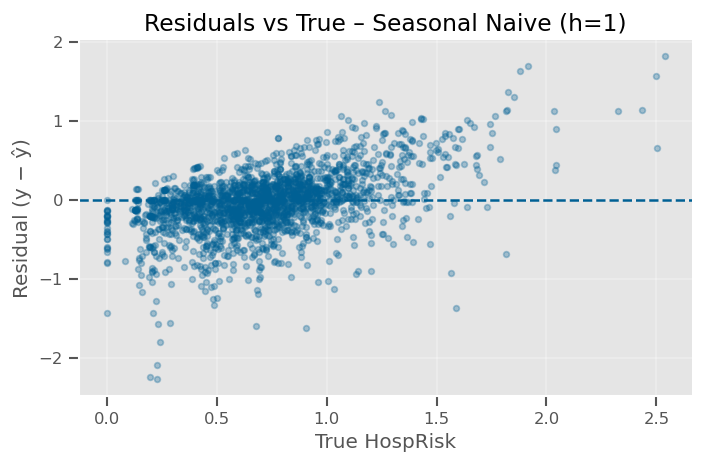

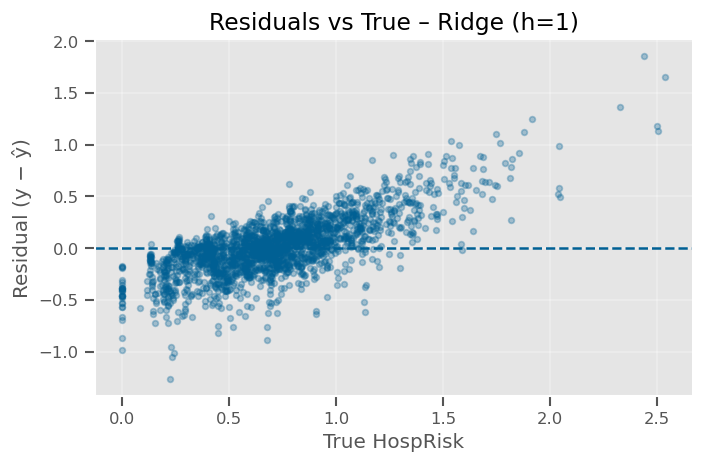

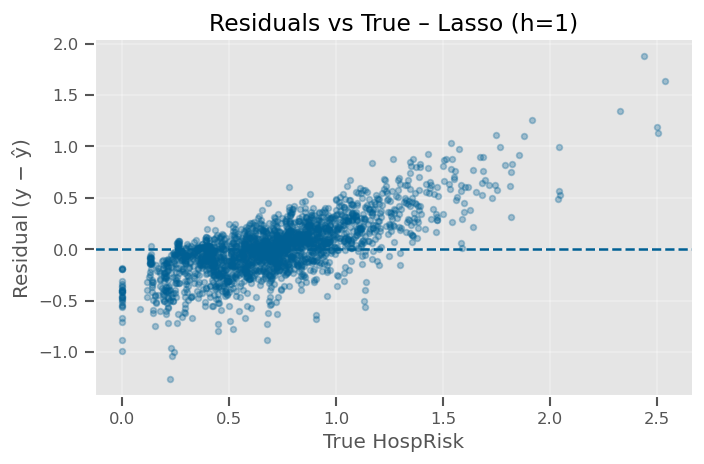

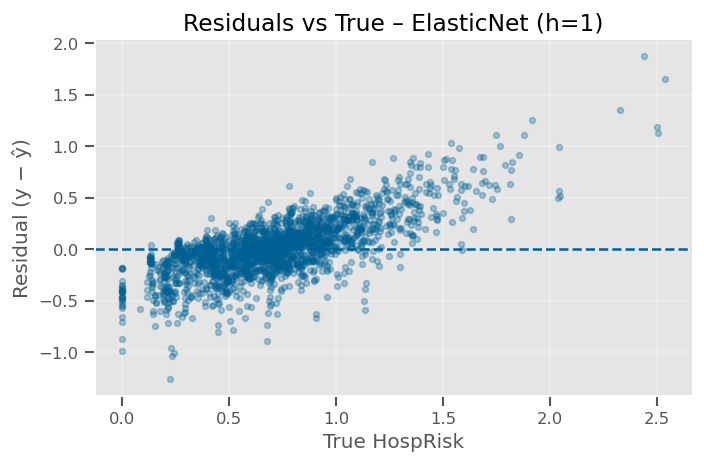

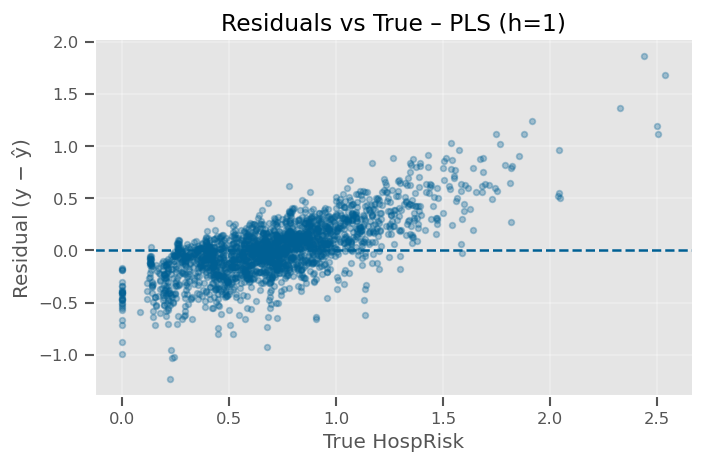

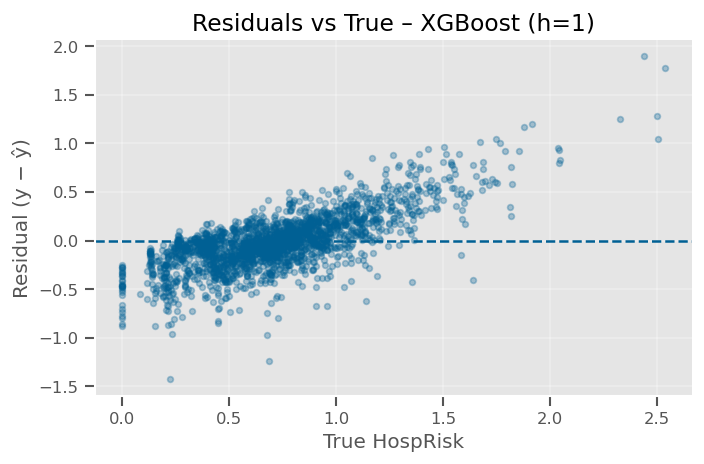

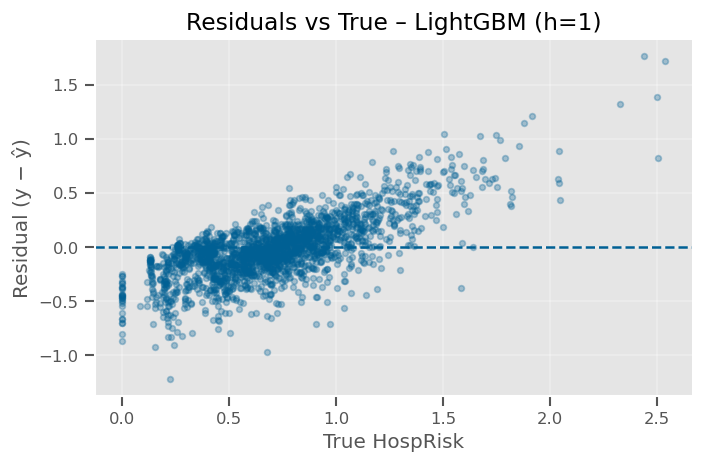

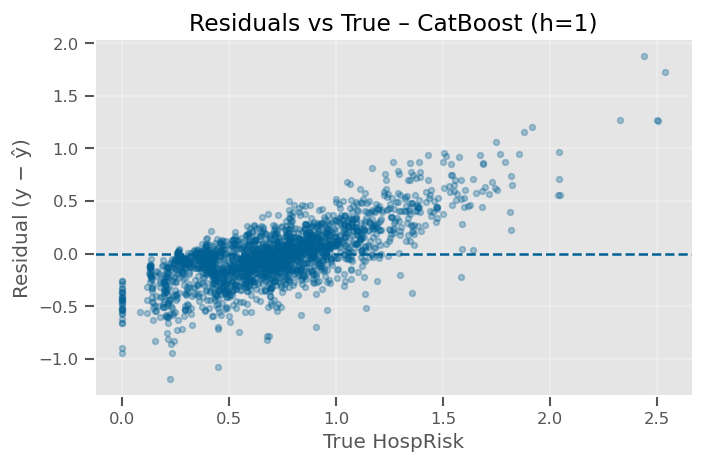

In [90]:
import matplotlib.pyplot as plt

h = 1
df_h = res_df[res_df["horizon"] == h]

for model in df_h["model"].unique():
    d = df_h[df_h["model"] == model]

    plt.figure(figsize=(6, 4))
    plt.scatter(
        d["y_true"],
        d["residual"],
        alpha=0.3,
        s=12
    )
    plt.axhline(0, linestyle="--")
    plt.xlabel("True HospRisk")
    plt.ylabel("Residual (y − ŷ)")
    plt.title(f"Residuals vs True – {model} (h={h})")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [35]:
metrics_df_m = (
    results_df_m
    .groupby(["train_end", "horizon", "model"])
    .apply(lambda d: pd.Series({
        "rmse": root_mean_squared_error(d["y_true"], d["y_pred"]),
        "mae": mean_absolute_error(d["y_true"], d["y_pred"]),
        "n_obs": len(d),
    }))
    .reset_index()
)

metrics_df_m

C:\Users\esper\AppData\Local\Temp\ipykernel_24620\371372589.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,train_end,horizon,model,rmse,mae,n_obs
0,2018-12-01,1,CatBoost,0.308057,0.228470,360.0
1,2018-12-01,1,ElasticNet,0.305181,0.228296,360.0
2,2018-12-01,1,Lasso,0.304479,0.227937,360.0
3,2018-12-01,1,LightGBM,0.307989,0.230513,360.0
4,2018-12-01,1,PLS,0.304551,0.228699,360.0
...,...,...,...,...,...,...
139,2023-12-01,6,LightGBM,0.280955,0.203521,180.0
140,2023-12-01,6,PLS,0.284898,0.210463,180.0
141,2023-12-01,6,Ridge,0.285365,0.210174,180.0
142,2023-12-01,6,Seasonal Naive,0.361870,0.251021,180.0


In [36]:
# baseline MAE per fold+horizon from SeasonalNaive
baseline_mae = (
    metrics_df_m
    .query("model == 'Seasonal Naive'")
    .loc[:, ["train_end", "horizon", "mae"]]
    .rename(columns={"mae": "mae_snaive"})
)

# merge + compute MASE
metrics_df_m = (
    metrics_df_m
    .merge(baseline_mae, on=["train_end", "horizon"], how="left")
)

metrics_df_m["mase"] = metrics_df_m["mae"] / metrics_df_m["mae_snaive"]


In [37]:
metrics_df_m["mae_snaive"].isna().sum()   # should be 0 (or explain if some folds/h missing)
(metrics_df_m["mae_snaive"] == 0).sum()   # should be 0; if not, we need a safe guard



np.int64(0)

In [38]:
summary_m = (
    metrics_df_m
    .groupby(["horizon", "model"])
    .agg(
        rmse_median=("rmse", "median"),
        rmse_q25=("rmse", lambda x: x.quantile(0.25)),
        rmse_q75=("rmse", lambda x: x.quantile(0.75)),
        mase_median=("mase", "median"),
        mase_q25=("mase", lambda x: x.quantile(0.25)),
        mase_q75=("mase", lambda x: x.quantile(0.75)),
    )
    .reset_index()
    .sort_values(["horizon", "rmse_median"])
)

summary_m


,horizon,model,rmse_median,rmse_q25,rmse_q75,mase_median,mase_q25,mase_q75
0,1,CatBoost,0.280038,0.264910,0.302426,0.754591,0.732088,0.757662
3,1,LightGBM,0.282610,0.266453,0.301848,0.757462,0.751761,0.763425
7,1,XGBoost,0.288261,0.268706,0.310277,0.762224,0.757439,0.764789
2,1,Lasso,0.288574,0.268753,0.299528,0.754982,0.731112,0.767079
1,1,ElasticNet,0.289308,0.269198,0.299721,0.757410,0.731373,0.768783
4,1,PLS,0.290131,0.269660,0.300396,0.760361,0.734612,0.770937
5,1,Ridge,0.290224,0.269093,0.300323,0.759393,0.732561,0.768059
6,1,Seasonal Naive,0.377741,0.370884,0.409728,1.000000,1.000000,1.000000
11,3,LightGBM,0.275497,0.271501,0.306972,0.757549,0.729263,0.783602
8,3,CatBoost,0.276097,0.268983,0.302298,0.749515,0.732370,0.766847


In [39]:
metrics_df_m["mae_improve_vs_snaive_pct"] = (1 - metrics_df_m["mase"]) * 100
metrics_df_m

,train_end,horizon,model,rmse,mae,n_obs,mae_snaive,mase,mae_improve_vs_snaive_pct
0,2018-12-01,1,CatBoost,0.308057,0.228470,360.0,0.302429,0.755450,24.454990
1,2018-12-01,1,ElasticNet,0.305181,0.228296,360.0,0.302429,0.754876,24.512429
2,2018-12-01,1,Lasso,0.304479,0.227937,360.0,0.302429,0.753688,24.631241
3,2018-12-01,1,LightGBM,0.307989,0.230513,360.0,0.302429,0.762205,23.779517
4,2018-12-01,1,PLS,0.304551,0.228699,360.0,0.302429,0.756209,24.379096
...,...,...,...,...,...,...,...,...,...
139,2023-12-01,6,LightGBM,0.280955,0.203521,180.0,0.251021,0.810772,18.922802
140,2023-12-01,6,PLS,0.284898,0.210463,180.0,0.251021,0.838427,16.157326
141,2023-12-01,6,Ridge,0.285365,0.210174,180.0,0.251021,0.837273,16.272661
142,2023-12-01,6,Seasonal Naive,0.361870,0.251021,180.0,0.251021,1.000000,0.000000


In [40]:
import matplotlib.pyplot as plt

def plot_rmse_per_horizon(metrics_df):
    # aggregate across folds (median is robust)
    rmse_summary = (
        metrics_df
        .groupby(["horizon", "model"])["rmse"]
        .median()
        .reset_index()
    )

    horizons = sorted(rmse_summary["horizon"].unique())

    plt.figure(figsize=(9, 5))

    for model, g in rmse_summary.groupby("model"):
        plt.plot(
            g["horizon"],
            g["rmse"],
            marker="o",
            label=model
        )

    plt.xlabel("Forecast horizon (months)")
    plt.ylabel("Median RMSE")
    plt.title("RMSE by model and forecast horizon")
    plt.grid(alpha=0.3)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()


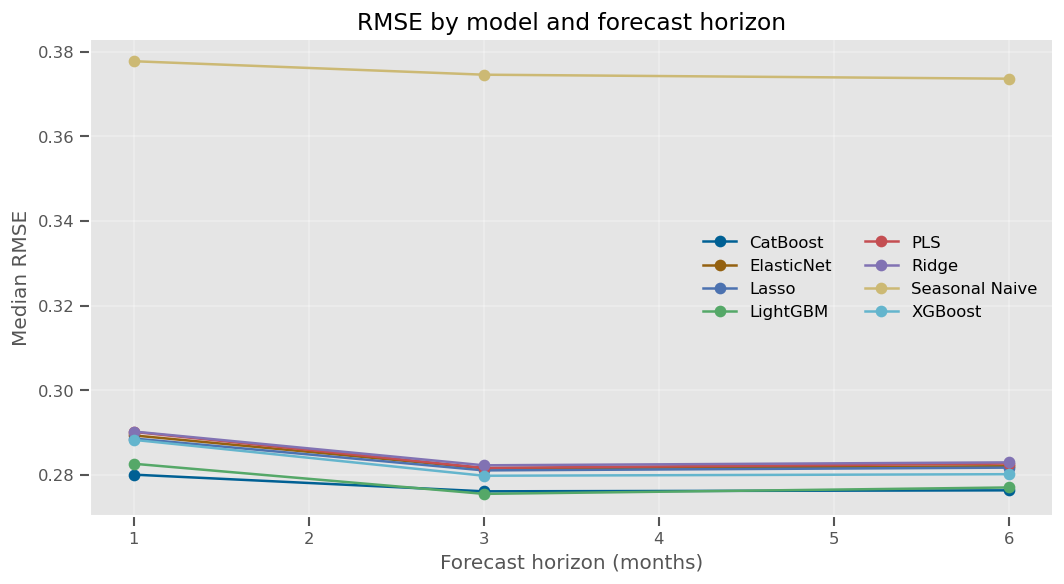

In [41]:
plot_rmse_per_horizon(metrics_df_m)


In [42]:
def plot_rmse_panels(metrics_df):
    rmse_summary = (
        metrics_df
        .groupby(["horizon", "model"])["rmse"]
        .median()
        .reset_index()
    )

    horizons = sorted(rmse_summary["horizon"].unique())

    fig, axes = plt.subplots(1, len(horizons), figsize=(14, 4), sharey=True)

    for ax, h in zip(axes, horizons):
        g = rmse_summary[rmse_summary["horizon"] == h].sort_values("rmse")

        ax.barh(g["model"], g["rmse"])
        ax.set_title(f"h = {h}")
        ax.grid(axis="x", alpha=0.3)

    axes[0].set_ylabel("Model")
    fig.suptitle("Median RMSE per horizon", y=1.02)
    plt.tight_layout()
    plt.show()


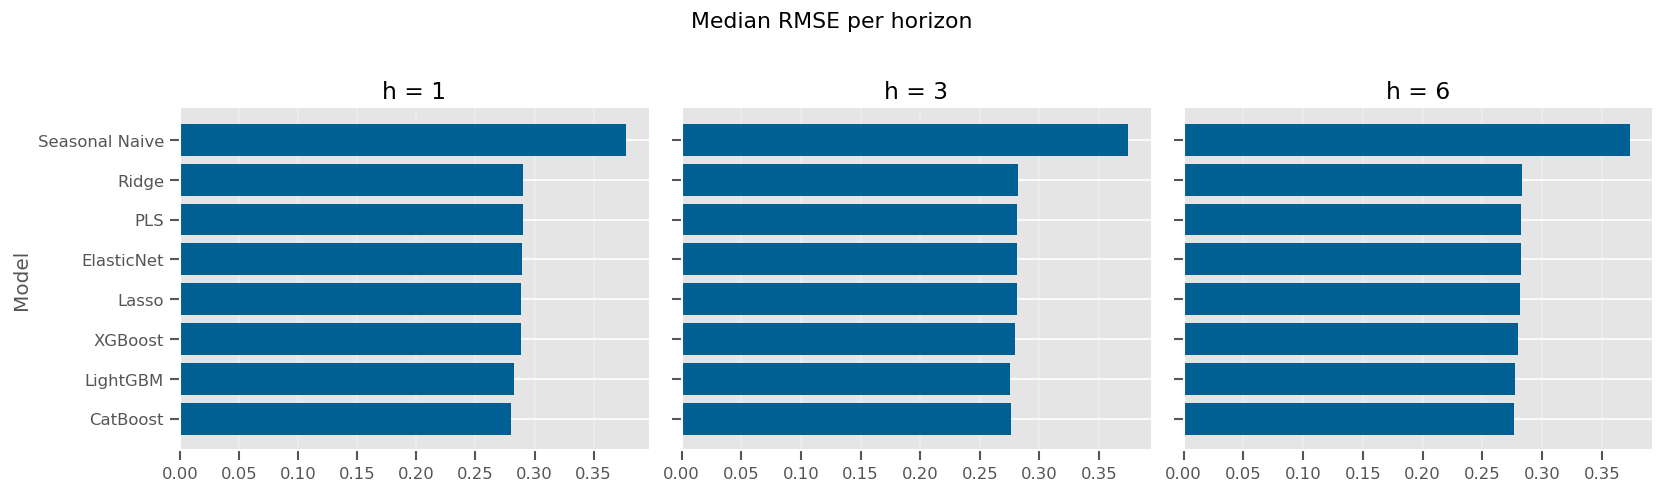

In [43]:
plot_rmse_panels(metrics_df_m)

In [44]:
rmse_by_fold = (
    metrics_df_m
    .groupby(["train_end", "horizon", "model"])["rmse"]
    .median()
    .reset_index()
)


In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_rmse_by_fold(rmse_by_fold):
    horizons = sorted(rmse_by_fold["horizon"].unique())

    fig, axes = plt.subplots(
        1, len(horizons), figsize=(16, 4), sharey=True
    )

    for ax, h in zip(axes, horizons):
        df_h = rmse_by_fold[rmse_by_fold["horizon"] == h]

        for model, g in df_h.groupby("model"):
            ax.plot(
                g["train_end"],
                g["rmse"],
                marker="o",
                alpha=0.7,
                label=model
            )

        ax.set_title(f"Horizon h = {h}")
        ax.xaxis.set_major_locator(mdates.YearLocator(1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.grid(alpha=0.3)

    axes[0].set_ylabel("RMSE")
    axes[0].legend(ncol=2, fontsize=9)
    fig.suptitle("RMSE across CV folds (rolling origin)", y=1.05)
    plt.tight_layout()
    plt.show()


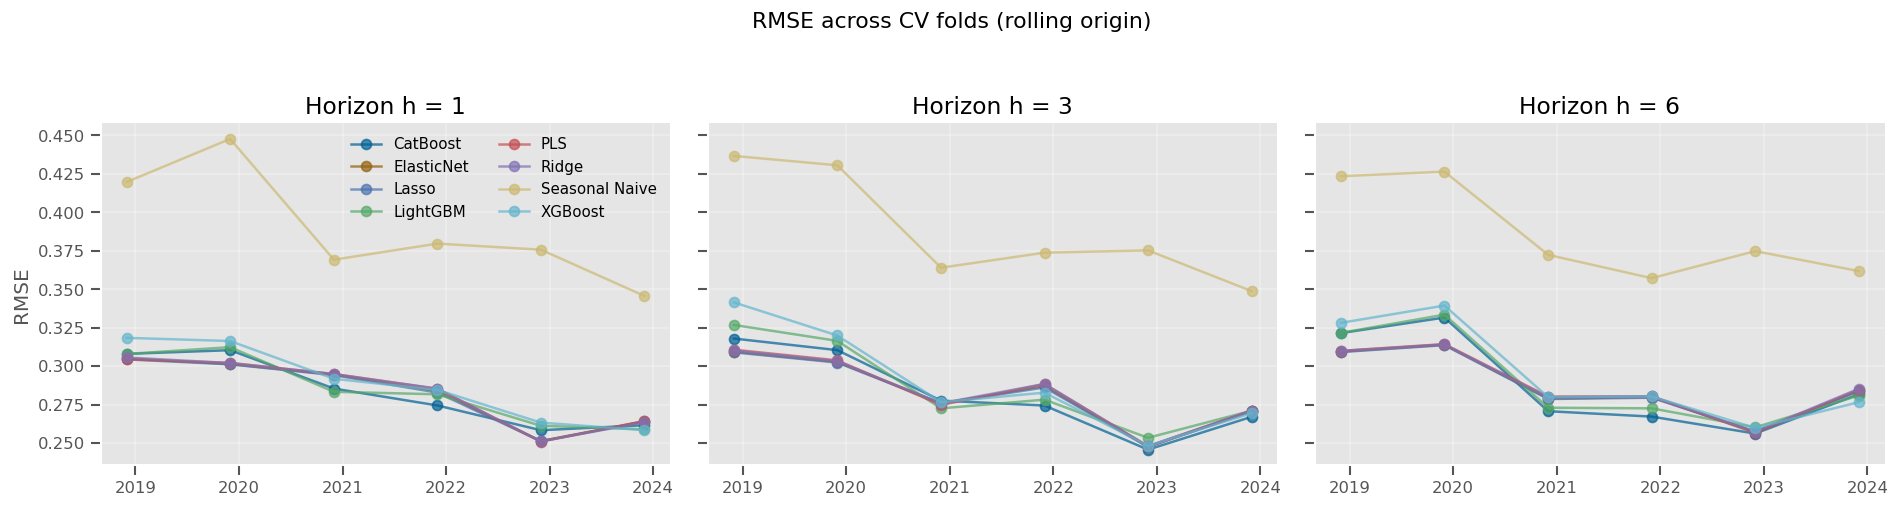

In [46]:
plot_rmse_by_fold(rmse_by_fold)


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_rmse_heatmap(
    rmse_by_fold,
    horizon,
    exclude_models=("Seasonal Naive",),
    every_n=1,
    fmt=".3f"
):
    # Filter horizon and exclude baseline
    df_h = rmse_by_fold[
        (rmse_by_fold["horizon"] == horizon) &
        (~rmse_by_fold["model"].isin(exclude_models))
    ]

    pivot = df_h.pivot(
        index="model",
        columns="train_end",
        values="rmse"
    )

    # Ensure datetime columns
    pivot.columns = pd.to_datetime(pivot.columns)

    plt.figure(figsize=(14, 4))
    ax = sns.heatmap(
        pivot,
        cmap="viridis",
        annot=True,          # <-- annotate cells
        fmt=fmt,             # format of numbers
        linewidths=0.3,
        cbar_kws={"label": "RMSE"}
    )

    # ---- Clean x-axis (years only, sparse ticks) ----
    cols = pivot.columns
    tick_idx = range(0, len(cols), every_n)

    ax.set_xticks(tick_idx)
    ax.set_xticklabels(
        [cols[i].strftime("%Y") for i in tick_idx],
        rotation=0
    )

    ax.set_xlabel("Train end (year)")
    ax.set_ylabel("Model")
    ax.set_title(f"RMSE across folds (h = {horizon})")

    plt.tight_layout()
    plt.show()


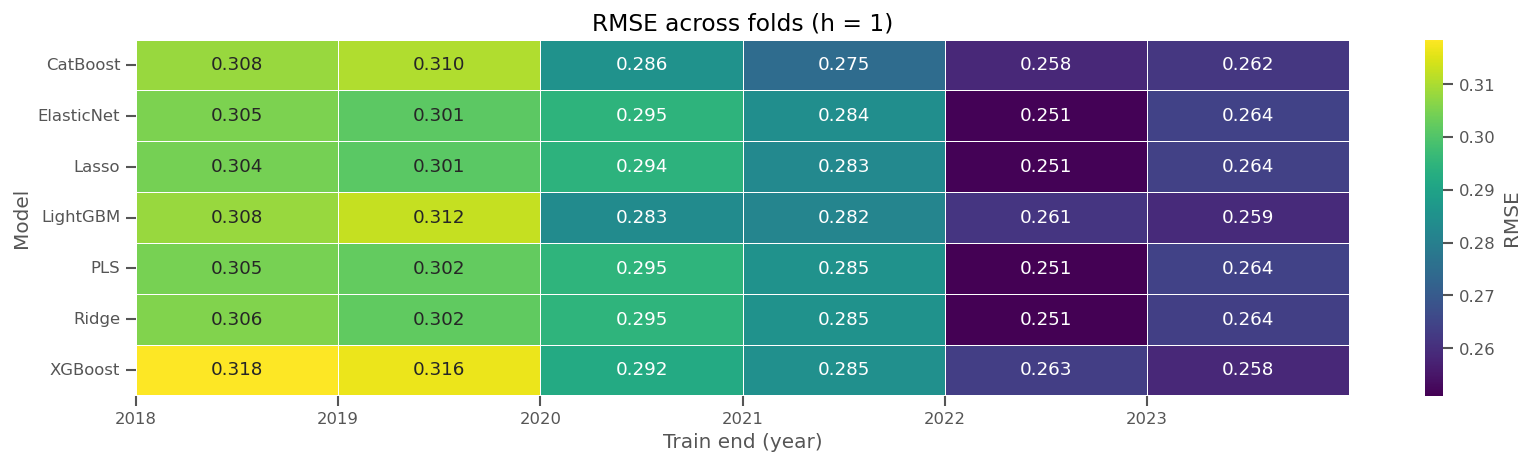

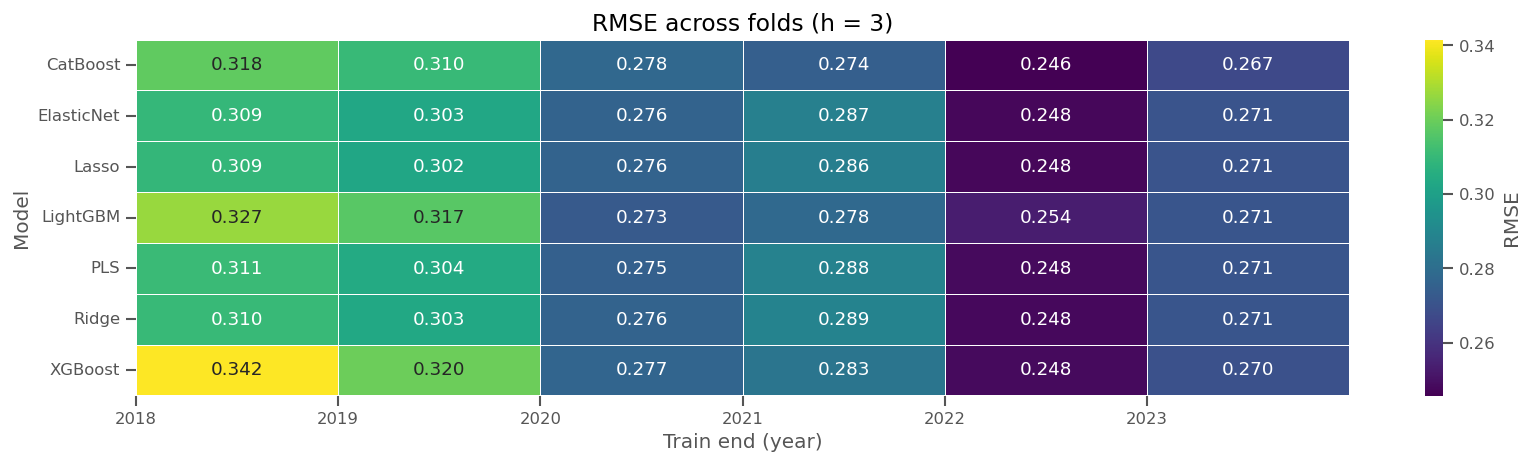

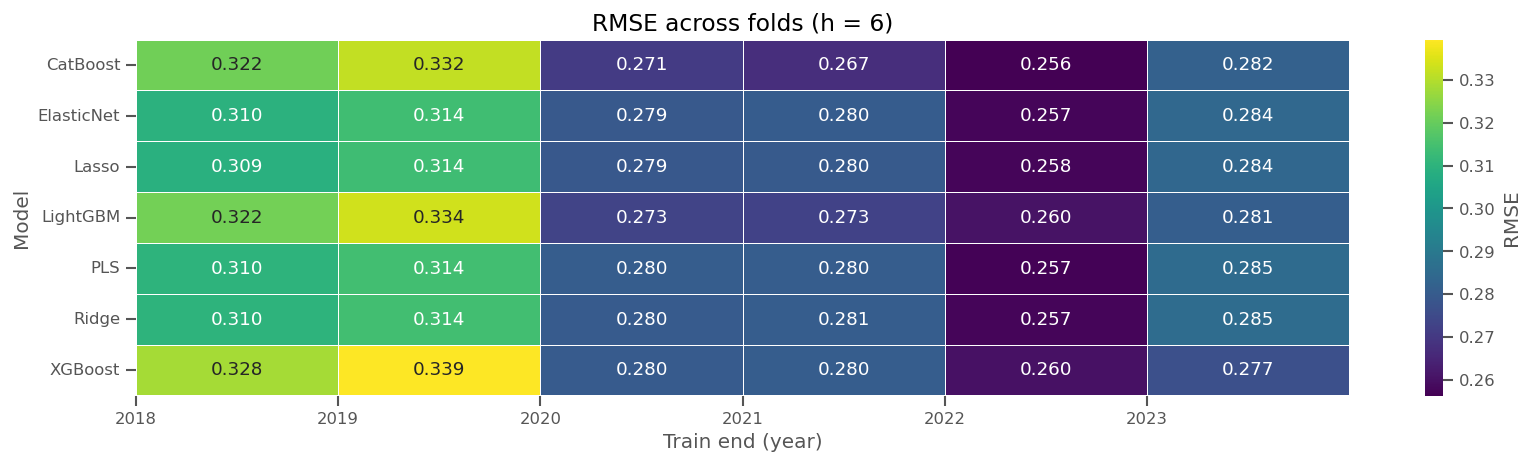

In [54]:
plot_rmse_heatmap(rmse_by_fold, horizon=1)
plot_rmse_heatmap(rmse_by_fold, horizon=3)
plot_rmse_heatmap(rmse_by_fold, horizon=6)

In [59]:
def contributing_months(results_df):
    df = results_df.copy()

    df["Date"] = pd.to_datetime(df["Date"])

    df["target_date"] = df.apply(
        lambda r: r["Date"] + pd.DateOffset(months=int(r["horizon"])),
        axis=1
    )

    df["target_month"] = df["target_date"].dt.month
    df["target_month_name"] = df["target_date"].dt.month_name()

    return df


In [60]:
months_df = contributing_months(results_df_m)


In [61]:
months_df = contributing_months(results_df_m)

months_df[["Date", "horizon", "target_date"]].head(10)


,Date,horizon,target_date
0,2019-01-01,1,2019-02-01
1,2019-02-01,1,2019-03-01
2,2019-03-01,1,2019-04-01
3,2019-04-01,1,2019-05-01
4,2019-05-01,1,2019-06-01
5,2019-06-01,1,2019-07-01
6,2019-07-01,1,2019-08-01
7,2019-08-01,1,2019-09-01
8,2019-09-01,1,2019-10-01
9,2019-10-01,1,2019-11-01


In [62]:
month_counts = (
    months_df
    .groupby(["horizon", "target_month", "target_month_name"])
    .size()
    .reset_index(name="n_obs")
    .sort_values(["horizon", "target_month"])
)


In [63]:
month_counts.head(12)


,horizon,target_month,target_month_name,n_obs
0,1,1,January,1200
1,1,2,February,1440
2,1,3,March,1440
3,1,4,April,1440
4,1,5,May,1440
5,1,6,June,1440
6,1,7,July,1440
7,1,8,August,1440
8,1,9,September,1440
9,1,10,October,1440


In [64]:

def plot_contributing_months(month_counts):
    horizons = sorted(month_counts["horizon"].unique())

    fig, axes = plt.subplots(1, len(horizons), figsize=(14, 4), sharey=True)

    for ax, h in zip(axes, horizons):
        df_h = month_counts[month_counts["horizon"] == h]

        ax.bar(
            df_h["target_month_name"],
            df_h["n_obs"]
        )
        ax.set_title(f"Horizon h = {h}")
        ax.set_xlabel("Target month")
        ax.tick_params(axis="x", rotation=45)
        ax.grid(axis="y", alpha=0.3)

    axes[0].set_ylabel("Number of evaluated predictions")
    fig.suptitle("Calendar months contributing to each forecast horizon", y=1.05)
    plt.tight_layout()
    plt.show()


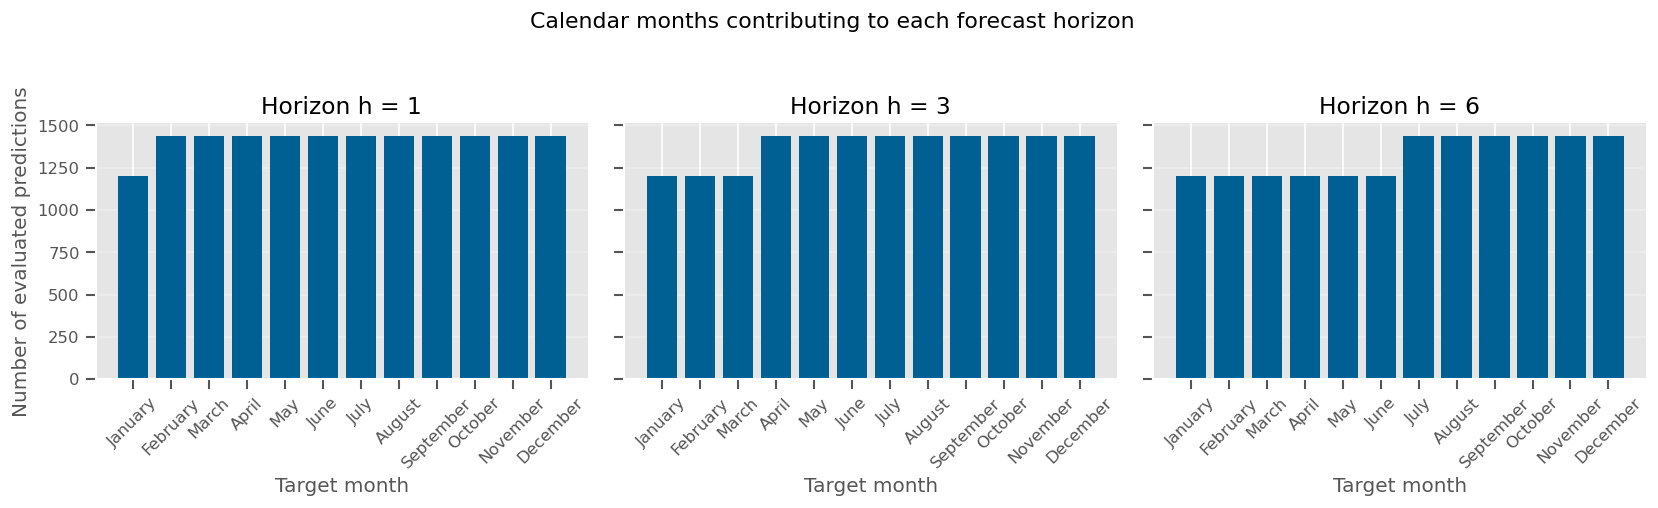

In [65]:
plot_contributing_months(month_counts)


In [67]:
df = pd.read_csv(DATA_DIR / "processed" / "federal_df.csv", parse_dates=['EventDate'])

C:\Users\esper\AppData\Local\Temp\ipykernel_24620\4269059861.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR / "processed" / "federal_df.csv", parse_dates=['EventDate'])


In [68]:
from src.features import compute_naics_mix

naics_mix = compute_naics_mix(
    df=df,
    naics_col="Primary NAICS",
    date_col="EventDate",
    state_col="State",
    freq="MS",
    top_k=10,
    out_date_col="Date"
)

In [69]:
naics_panel = monthly_complete.merge(
    naics_mix,
    on=['State', 'Date'],
    how="left",
)

In [70]:
naics_panel.head()

,State,Date,HospRisk,share_NAICS2_23,share_NAICS2_31,share_NAICS2_32,share_NAICS2_33,share_NAICS2_42,share_NAICS2_44,share_NAICS2_48,share_NAICS2_49,share_NAICS2_56,share_NAICS2_62,share_NAICS2_Other
0,ALABAMA,2015-01-01,0.714760,0.047619,0.047619,0.476190,0.190476,0.047619,0.000000,0.000000,0.000000,0.047619,0.00,0.142857
1,ALABAMA,2015-02-01,0.765072,0.100000,0.050000,0.150000,0.500000,0.050000,0.000000,0.050000,0.000000,0.050000,0.05,0.000000
2,ALABAMA,2015-03-01,1.123538,0.080000,0.080000,0.200000,0.280000,0.000000,0.120000,0.000000,0.000000,0.000000,0.04,0.200000
3,ALABAMA,2015-04-01,1.070064,0.037037,0.185185,0.296296,0.185185,0.037037,0.074074,0.000000,0.000000,0.074074,0.00,0.111111
4,ALABAMA,2015-05-01,1.168046,0.193548,0.096774,0.161290,0.290323,0.000000,0.000000,0.032258,0.064516,0.064516,0.00,0.096774


In [71]:
share_cols = [c for c in naics_panel.columns if c.startswith("share_NAICS2_")]
naics_panel[share_cols] = naics_panel[share_cols].fillna(0.0)

In [72]:
from src.features import build_panel_features

X_m_s, y_m_s, meta_m_s = build_panel_features(
    panel_df=naics_panel,
    target="HospRisk",
    group_col="State",
    date_col="Date",
    freq="MS",
    add_calendar=True,
    add_lags=True,
    add_rolling=True,
    add_ewm=True,
    lags=(1, 2, 3, 6, 12),
    rolling_windows=(3, 6, 12),
    ewm_spans=(3, 6, 12),
    state_encoding='dummy',
    naics_mix_cols=share_cols,
    dropna=True,
)

X_m_s.head(), y_m_s.head(), meta_m_s.head()


(   year  month  quarter  month_sin     month_cos  HospRisk_lag1  \
 0  2016      1        1   0.500000  8.660254e-01       0.604047   
 1  2016      2        1   0.866025  5.000000e-01       1.458312   
 2  2016      3        1   1.000000  6.123234e-17       0.854744   
 3  2016      4        2   0.866025 -5.000000e-01       0.854186   
 4  2016      5        2   0.500000 -8.660254e-01       1.052368   
 
    HospRisk_lag2  HospRisk_lag3  HospRisk_lag6  HospRisk_lag12  ...  \
 0       0.907441       1.313065       1.268649        0.714760  ...   
 1       0.604047       0.907441       1.164498        0.765072  ...   
 2       1.458312       0.604047       0.758802        1.123538  ...   
 3       0.854744       1.458312       1.313065        1.070064  ...   
 4       0.854186       0.854744       0.907441        1.168046  ...   
 
    share_NAICS2_31_lag1  share_NAICS2_32_lag1  share_NAICS2_33_lag1  \
 0              0.055556              0.277778              0.388889   
 1          

In [73]:
from sklearn.metrics import mean_absolute_error

results_rows_m_s = []
perm_rows_m_s = []

horizons = [1, 3, 6]

for split in splits_origins:
    train_end = split["train_end"]

    for h in horizons:
        # --------------------------------------------------
        # 1. Direct multi-step target
        # --------------------------------------------------
        y_h = (
            y_m_s
            .groupby(meta_m_s["State"], sort=False)
            .shift(-h)
        )

        y_naive = y_m_s.groupby(meta_m_s["State"], sort=False).shift(12 - h)
        
        valid_mask = y_h.notna()

        train_mask = split["train_mask"] & valid_mask
        test_mask  = split["test_mask"]  & valid_mask

        valid_mask_naive = valid_mask & (y_naive.notna())
        test_mask_naive = split["test_mask"]  & valid_mask_naive

        X_train = X_m_s.loc[train_mask]
        y_train = y_h.loc[train_mask]
        meta_train = meta_m_s.loc[train_mask]

        X_test = X_m_s.loc[test_mask]
        y_test = y_h.loc[test_mask]
        meta_test = meta_m_s.loc[test_mask]

        # --------------------------------------------------
        # 2. Instantiate and fit global models
        # --------------------------------------------------
        model_configs = get_model_configs(
            n_samples=len(X_train),
            use_linear=True,
            use_tree=True,
            random_state=0,
            n_jobs=-1,
        )
        models = instantiate_models(model_configs)

        fitted = fit_global_models(
            models=models,
            X_train=X_train,
            y_train=y_train,
        )

        # for baseline, store naive predictions
        tmp_naive = meta_m_s.loc[test_mask_naive].copy()
        tmp_naive["train_end"] = train_end
        tmp_naive["horizon"] = h
        tmp_naive["model"] = "Seasonal Naive"
        tmp_naive["y_true"] = y_h.loc[test_mask_naive].values
        tmp_naive["y_pred"] = y_naive.loc[test_mask_naive].values
        results_rows_m_s.append(tmp_naive)
        # --------------------------------------------------
        # 3. Predict and store results (TEST only)
        # --------------------------------------------------
        for model_name, model in fitted.items():
            y_pred = model.predict(X_test)

            tmp = meta_test.copy()
            tmp["train_end"] = train_end
            tmp["horizon"] = h
            tmp["model"] = model_name
            tmp["y_true"] = y_test.values
            tmp["y_pred"] = y_pred

            pi = permutation_importance(
                model,
                X_test,
                y_test,
                scoring=neg_rmse_scorer,
                n_repeats=5,
                random_state=0,
                n_jobs=-1,
            )

            imp = pd.DataFrame({
                "feature": X_test.columns,
                "importance": pi.importances_mean,
                "importance_std": pi.importances_std,
            })
            imp["train_end"] = train_end
            imp["horizon"] = h
            imp["model"] = model_name

            perm_rows_m_s.append(imp)
            results_rows_m_s.append(tmp)


In [75]:
results_df_m_s = pd.concat(results_rows_m_s, ignore_index=True)

results_df_m_s.head()



,State,Date,train_end,horizon,model,y_true,y_pred
0,ALABAMA,2019-01-01,2018-12-01,1,Seasonal Naive,1.209190,1.279779
1,ALABAMA,2019-02-01,2018-12-01,1,Seasonal Naive,1.062597,0.933248
2,ALABAMA,2019-03-01,2018-12-01,1,Seasonal Naive,1.541574,1.127949
3,ALABAMA,2019-04-01,2018-12-01,1,Seasonal Naive,1.299764,1.862289
4,ALABAMA,2019-05-01,2018-12-01,1,Seasonal Naive,1.299139,1.366921


In [76]:
metrics_df_m_s = (
    results_df_m_s
    .groupby(["train_end", "horizon", "model"])
    .apply(lambda d: pd.Series({
        "rmse": root_mean_squared_error(d["y_true"], d["y_pred"]),
        "mae": mean_absolute_error(d["y_true"], d["y_pred"]),
        "n_obs": len(d),
    }))
    .reset_index()
)

metrics_df_m_s

C:\Users\esper\AppData\Local\Temp\ipykernel_24620\3893318707.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,train_end,horizon,model,rmse,mae,n_obs
0,2018-12-01,1,CatBoost,0.306133,0.228192,360.0
1,2018-12-01,1,ElasticNet,0.298810,0.226955,360.0
2,2018-12-01,1,Lasso,0.296552,0.225556,360.0
3,2018-12-01,1,LightGBM,0.307818,0.229239,360.0
4,2018-12-01,1,PLS,0.300154,0.229494,360.0
...,...,...,...,...,...,...
139,2023-12-01,6,LightGBM,0.293632,0.211213,180.0
140,2023-12-01,6,PLS,0.275052,0.200841,180.0
141,2023-12-01,6,Ridge,0.278065,0.202495,180.0
142,2023-12-01,6,Seasonal Naive,0.361870,0.251021,180.0


In [77]:
def summarize_rmse(metrics_df):
    return (
        metrics_df
        .groupby(["horizon", "model"])["rmse"]
        .median()
        .reset_index(name="rmse")
    )

rmse_base = summarize_rmse(metrics_df_m)
rmse_ext  = summarize_rmse(metrics_df_m_s)

rmse_base["experiment"] = "Baseline"
rmse_ext["experiment"]  = "State + NAICS"

rmse_cmp = pd.concat([rmse_base, rmse_ext], ignore_index=True)
rmse_cmp


,horizon,model,rmse,experiment
0,1,CatBoost,0.280038,Baseline
1,1,ElasticNet,0.289308,Baseline
2,1,Lasso,0.288574,Baseline
3,1,LightGBM,0.282610,Baseline
4,1,PLS,0.290131,Baseline
5,1,Ridge,0.290224,Baseline
6,1,Seasonal Naive,0.377741,Baseline
7,1,XGBoost,0.288261,Baseline
8,3,CatBoost,0.276097,Baseline
9,3,ElasticNet,0.281548,Baseline


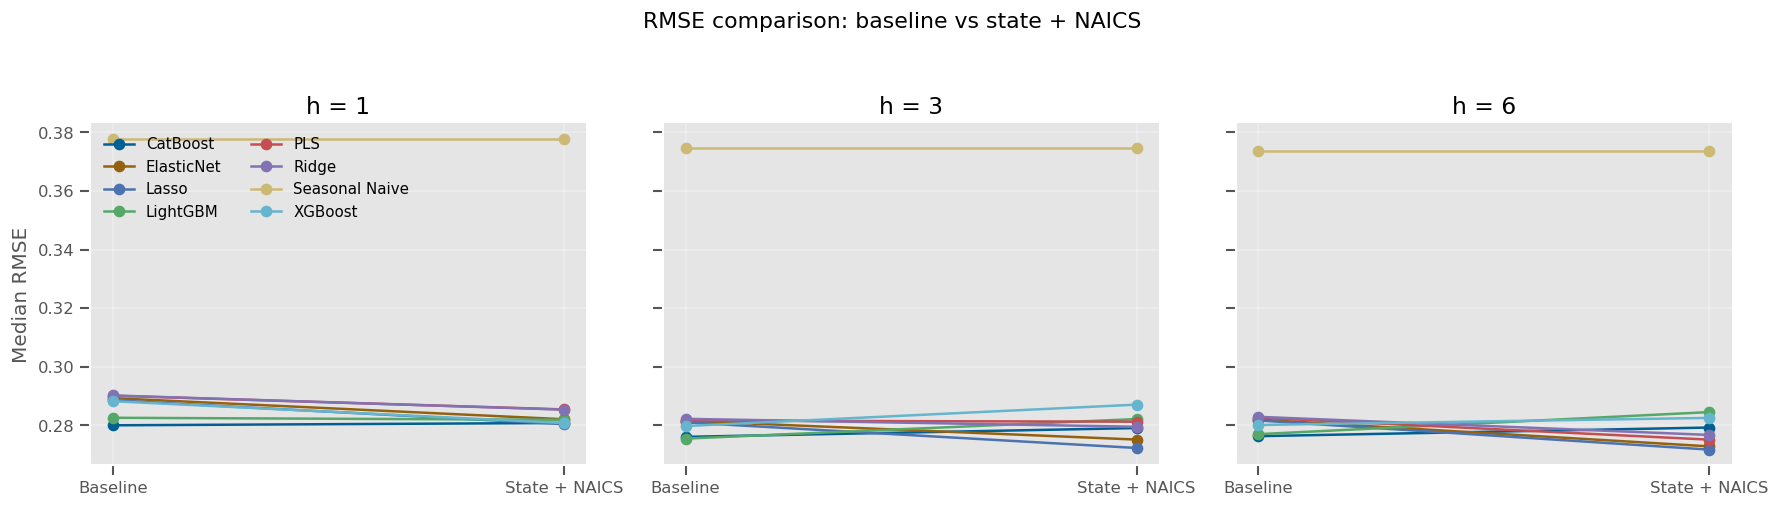

In [78]:
import matplotlib.pyplot as plt

def plot_rmse_experiment_comparison(rmse_cmp):
    horizons = sorted(rmse_cmp["horizon"].unique())

    fig, axes = plt.subplots(1, len(horizons), figsize=(15, 4), sharey=True)

    for ax, h in zip(axes, horizons):
        df_h = rmse_cmp[rmse_cmp["horizon"] == h]

        for model, g in df_h.groupby("model"):
            ax.plot(
                g["experiment"],
                g["rmse"],
                marker="o",
                label=model
            )

        ax.set_title(f"h = {h}")
        ax.set_xlabel("")
        ax.grid(alpha=0.3)

    axes[0].set_ylabel("Median RMSE")
    axes[0].legend(ncol=2, fontsize=9, loc="upper left")
    fig.suptitle("RMSE comparison: baseline vs state + NAICS", y=1.05)
    plt.tight_layout()
    plt.show()
plot_rmse_experiment_comparison(rmse_cmp)

In [79]:
rmse_delta = (
    rmse_base
    .merge(
        rmse_ext,
        on=["horizon", "model"],
        suffixes=("_baseline", "_extended")
    )
)

rmse_delta["delta_rmse"] = rmse_delta["rmse_extended"] - rmse_delta["rmse_baseline"]
rmse_delta.sort_values(["horizon", "delta_rmse"])


,horizon,model,rmse_baseline,experiment_baseline,rmse_extended,experiment_extended,delta_rmse
2,1,Lasso,0.288574,Baseline,0.280436,State + NAICS,-0.008138
7,1,XGBoost,0.288261,Baseline,0.280806,State + NAICS,-0.007455
1,1,ElasticNet,0.289308,Baseline,0.282104,State + NAICS,-0.007204
5,1,Ridge,0.290224,Baseline,0.285380,State + NAICS,-0.004844
4,1,PLS,0.290131,Baseline,0.285459,State + NAICS,-0.004672
3,1,LightGBM,0.282610,Baseline,0.281925,State + NAICS,-0.000685
6,1,Seasonal Naive,0.377741,Baseline,0.377741,State + NAICS,0.000000
0,1,CatBoost,0.280038,Baseline,0.280834,State + NAICS,0.000796
10,3,Lasso,0.281046,Baseline,0.272301,State + NAICS,-0.008745
9,3,ElasticNet,0.281548,Baseline,0.275170,State + NAICS,-0.006378


In [80]:

perm_df_m_s = pd.concat(perm_rows_m_s, ignore_index=True)


In [81]:
imp_summary_m_s = (
    perm_df_m_s
    .groupby(["model", "horizon", "feature"])["importance"]
    .agg(
        median="median",
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75),
    )
    .reset_index()
)

imp_summary_m_s["iqr"] = imp_summary_m_s["q75"] - imp_summary_m_s["q25"]


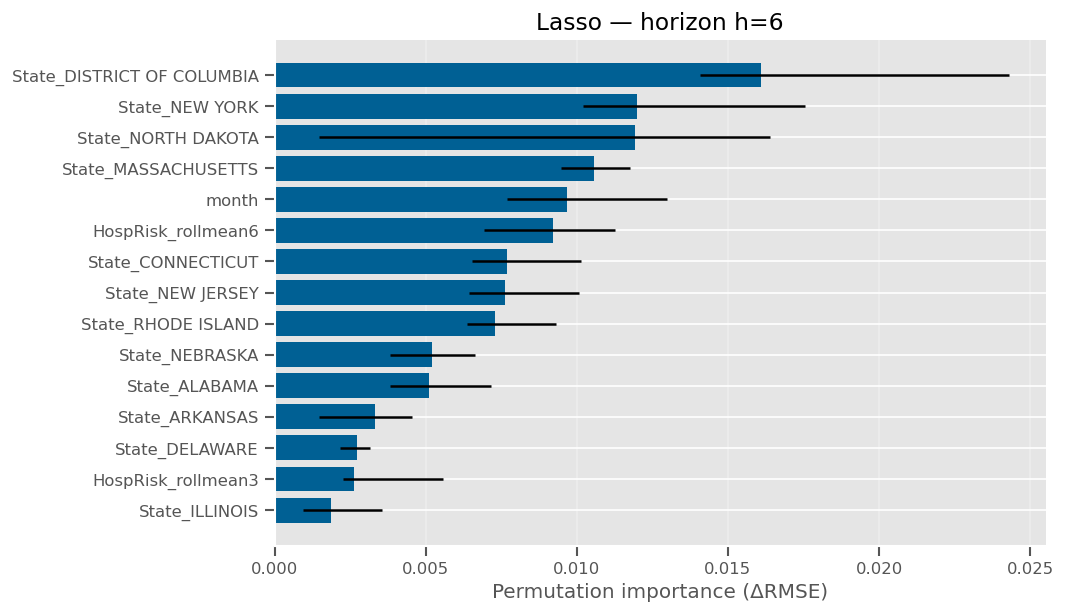

In [84]:

def plot_perm_importance_topk(
    imp_summary,
    model,
    horizon,
    k=15
):
    df = (
        imp_summary
        [(imp_summary["model"] == model) & (imp_summary["horizon"] == horizon)]
        .sort_values("median", ascending=False)
        .head(k)
        .sort_values("median")
    )

    x = df["median"].values
    y = df["feature"].values
    xerr = np.vstack([x - df["q25"].values, df["q75"].values - x])

    plt.figure(figsize=(9, max(4, 0.35 * len(df))))
    plt.barh(y, x, xerr=xerr)
    plt.xlabel("Permutation importance (ΔRMSE)")
    plt.title(f"{model} — horizon h={horizon}")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_perm_importance_topk(
    imp_summary=imp_summary_m_s, model="Lasso", horizon=6)

In [91]:
from sklearn.preprocessing import PowerTransformer


In [92]:
from sklearn.metrics import mean_absolute_error

results_rows_trans = []
perm_trans_rows = []

horizons = [1, 3, 6]

for split in splits_origins:
    train_end = split["train_end"]

    for h in horizons:
        # --------------------------------------------------
        # 1. Direct multi-step target
        # --------------------------------------------------
        y_h = (
            y_m
            .groupby(meta_m["State"], sort=False)
            .shift(-h)
        )

        y_naive = y_m.groupby(meta_m["State"], sort=False).shift(12 - h)
        
        valid_mask = y_h.notna()

        train_mask = split["train_mask"] & valid_mask
        test_mask  = split["test_mask"]  & valid_mask

        valid_mask_naive = valid_mask & (y_naive.notna())
        test_mask_naive = split["test_mask"]  & valid_mask_naive

        X_train = X_m.loc[train_mask]
        y_train = y_h.loc[train_mask]
        meta_train = meta_m.loc[train_mask]

        X_test = X_m.loc[test_mask]
        y_test = y_h.loc[test_mask]
        meta_test = meta_m.loc[test_mask]

        pt = PowerTransformer(method="yeo-johnson", standardize=False)

        y_train_t = pt.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        y_test_t  = pt.transform(y_test.values.reshape(-1, 1)).ravel()
        # --------------------------------------------------
        # 2. Instantiate and fit global models
        # --------------------------------------------------
        model_configs = get_model_configs(
            n_samples=len(X_train),
            use_linear=True,
            use_tree=True,
            random_state=0,
            n_jobs=-1,
        )
        models = instantiate_models(model_configs)

        fitted = fit_global_models(
            models=models,
            X_train=X_train,
            y_train=y_train_t,
        )

        # for baseline, store naive predictions
        tmp_naive = meta_m.loc[test_mask_naive].copy()
        tmp_naive["train_end"] = train_end
        tmp_naive["horizon"] = h
        tmp_naive["model"] = "Seasonal Naive"
        tmp_naive["y_true"] = y_h.loc[test_mask_naive].values
        tmp_naive["y_pred"] = y_naive.loc[test_mask_naive].values
        results_rows_m.append(tmp_naive)
        # --------------------------------------------------
        # 3. Predict and store results (TEST only)
        # --------------------------------------------------
        for model_name, model in fitted.items():
            y_pred_t = model.predict(X_test)
            y_pred   = pt.inverse_transform(np.asarray(y_pred_t).reshape(-1, 1)).ravel()

            tmp = meta_test.copy()
            tmp["train_end"] = train_end
            tmp["horizon"] = h
            tmp["model"] = model_name
            tmp["y_true"] = y_test.values
            tmp["y_pred"] = y_pred

            pi = permutation_importance(
                model,
                X_test,
                y_test_t,
                scoring=neg_rmse_scorer,
                n_repeats=5,
                random_state=0,
                n_jobs=-1,
            )

            imp = pd.DataFrame({
                "feature": X_test.columns,
                "importance": pi.importances_mean,
                "importance_std": pi.importances_std,
            })
            imp["train_end"] = train_end
            imp["horizon"] = h
            imp["model"] = model_name

            perm_trans_rows.append(imp)
            results_rows_trans.append(tmp)
 # for permutation importance scoring


In [93]:
results_df_trans = pd.concat(results_rows_trans, ignore_index=True)

# Ensure numeric
results_df_trans["y_true"] = pd.to_numeric(results_df_trans["y_true"], errors="coerce")
results_df_trans["y_pred"] = pd.to_numeric(results_df_trans["y_pred"], errors="coerce")

# Residuals on original scale
results_df_trans["residual"] = results_df_trans["y_true"] - results_df_trans["y_pred"]

results_df_trans.head()

,State,Date,train_end,horizon,model,y_true,y_pred,residual
0,ALABAMA,2019-01-01,2018-12-01,1,Ridge,1.209190,1.203886,0.005304
1,ALABAMA,2019-02-01,2018-12-01,1,Ridge,1.062597,1.291725,-0.229129
2,ALABAMA,2019-03-01,2018-12-01,1,Ridge,1.541574,1.294337,0.247237
3,ALABAMA,2019-04-01,2018-12-01,1,Ridge,1.299764,1.400046,-0.100282
4,ALABAMA,2019-05-01,2018-12-01,1,Ridge,1.299139,1.540188,-0.241049


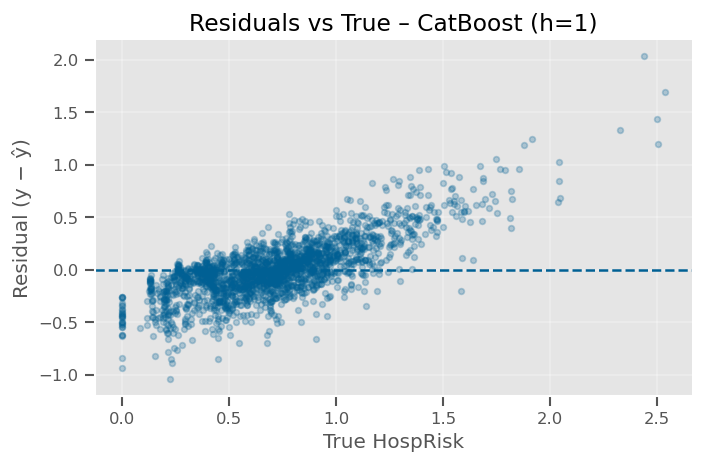

In [95]:
h = 1
model_name = "CatBoost"   # change as needed

d = results_df_trans[(results_df_trans["horizon"] == h) & (results_df_trans["model"] == model_name)].copy()

plt.figure(figsize=(6, 4))
plt.scatter(d["y_true"], d["residual"], alpha=0.25, s=12)
plt.axhline(0, linestyle="--")
plt.title(f"Residuals vs True – {model_name} (h={h})")
plt.xlabel("True HospRisk")
plt.ylabel("Residual (y − ŷ)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [96]:
metrics_df_trans = (
    results_df_trans
    .groupby(["train_end", "horizon", "model"])
    .apply(lambda d: pd.Series({
        "rmse": root_mean_squared_error(d["y_true"], d["y_pred"]),
        "mae": mean_absolute_error(d["y_true"], d["y_pred"]),
        "n_obs": len(d),
    }))
    .reset_index()
)

metrics_df_trans

C:\Users\esper\AppData\Local\Temp\ipykernel_24620\1338203598.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,train_end,horizon,model,rmse,mae,n_obs
0,2018-12-01,1,CatBoost,0.309362,0.226870,360.0
1,2018-12-01,1,ElasticNet,0.310336,0.229407,360.0
2,2018-12-01,1,Lasso,0.309441,0.228956,360.0
3,2018-12-01,1,LightGBM,0.309700,0.228804,360.0
4,2018-12-01,1,PLS,0.310538,0.229700,360.0
...,...,...,...,...,...,...
121,2023-12-01,6,Lasso,0.292667,0.217193,180.0
122,2023-12-01,6,LightGBM,0.284741,0.204908,180.0
123,2023-12-01,6,PLS,0.293451,0.217478,180.0
124,2023-12-01,6,Ridge,0.294078,0.217805,180.0


In [97]:

# rename RMSE columns to avoid confusion
m_before = metrics_df_m.rename(columns={"rmse": "rmse_raw"})
m_after  = metrics_df_trans.rename(columns={"rmse": "rmse_trans"})

# merge
cmp = (
    m_before
    .merge(
        m_after[["train_end", "horizon", "model", "rmse_trans"]],
        on=["train_end", "horizon", "model"],
        how="inner",
    )
)

cmp.head()


,train_end,horizon,model,rmse_raw,mae,n_obs,mae_snaive,mase,mae_improve_vs_snaive_pct,rmse_trans
0,2018-12-01,1,CatBoost,0.308057,0.228470,360.0,0.302429,0.755450,24.454990,0.309362
1,2018-12-01,1,ElasticNet,0.305181,0.228296,360.0,0.302429,0.754876,24.512429,0.310336
2,2018-12-01,1,Lasso,0.304479,0.227937,360.0,0.302429,0.753688,24.631241,0.309441
3,2018-12-01,1,LightGBM,0.307989,0.230513,360.0,0.302429,0.762205,23.779517,0.309700
4,2018-12-01,1,PLS,0.304551,0.228699,360.0,0.302429,0.756209,24.379096,0.310538


In [98]:
cmp["rmse_diff"] = cmp["rmse_trans"] - cmp["rmse_raw"]
cmp["rmse_pct"]  = 100 * cmp["rmse_diff"] / cmp["rmse_raw"]

cmp.head()


,train_end,horizon,model,rmse_raw,mae,n_obs,mae_snaive,mase,mae_improve_vs_snaive_pct,rmse_trans,rmse_diff,rmse_pct
0,2018-12-01,1,CatBoost,0.308057,0.228470,360.0,0.302429,0.755450,24.454990,0.309362,0.001305,0.423776
1,2018-12-01,1,ElasticNet,0.305181,0.228296,360.0,0.302429,0.754876,24.512429,0.310336,0.005156,1.689400
2,2018-12-01,1,Lasso,0.304479,0.227937,360.0,0.302429,0.753688,24.631241,0.309441,0.004963,1.629915
3,2018-12-01,1,LightGBM,0.307989,0.230513,360.0,0.302429,0.762205,23.779517,0.309700,0.001710,0.555344
4,2018-12-01,1,PLS,0.304551,0.228699,360.0,0.302429,0.756209,24.379096,0.310538,0.005988,1.966042


In [99]:
summary_model = (
    cmp
    .groupby("model")
    .agg(
        rmse_raw_mean=("rmse_raw", "mean"),
        rmse_trans_mean=("rmse_trans", "mean"),
        rmse_diff_mean=("rmse_diff", "mean"),
        rmse_pct_mean=("rmse_pct", "mean"),
        n=("rmse_raw", "count"),
    )
    .sort_values("rmse_diff_mean")
    .round(4)
)

summary_model


,rmse_raw_mean,rmse_trans_mean,rmse_diff_mean,rmse_pct_mean,n
model,,,,,
XGBoost,0.2909,0.2883,-0.0026,-0.7508,18
CatBoost,0.2846,0.2832,-0.0013,-0.3572,18
LightGBM,0.2871,0.2870,-0.0000,0.0898,18
Lasso,0.2840,0.2876,0.0035,1.3000,18
ElasticNet,0.2844,0.2880,0.0036,1.3261,18
PLS,0.2848,0.2886,0.0038,1.3813,18
Ridge,0.2849,0.2888,0.0040,1.4301,18


In [100]:
summary_model_h = (
    cmp
    .groupby(["model", "horizon"])
    .agg(
        rmse_raw_mean=("rmse_raw", "mean"),
        rmse_trans_mean=("rmse_trans", "mean"),
        rmse_diff_mean=("rmse_diff", "mean"),
    )
    .round(4)
)

summary_model_h


rmse_raw_mean  rmse_trans_mean  rmse_diff_mean
model      horizon                                                
CatBoost   1               0.2831           0.2817         -0.0014
           3               0.2823           0.2808         -0.0015
           6               0.2882           0.2872         -0.0010
ElasticNet 1               0.2835           0.2862          0.0027
           3               0.2823           0.2858          0.0035
           6               0.2873           0.2921          0.0048
Lasso      1               0.2830           0.2856          0.0025
           3               0.2820           0.2854          0.0034
           6               0.2871           0.2917          0.0046
LightGBM   1               0.2843           0.2856          0.0012
           3               0.2865           0.2852         -0.0013
           6               0.2904           0.2904         -0.0000
PLS        1               0.2838           0.2869          0.0031
           3               0.2829           0.2864          0.0036
           6               0.2878           0.2925          0.0047
Ridge      1               0.2838           0.2871          0.0033
           3               0.2829           0.2866          0.0037
           6               0.2879           0.2927          0.0048
XGBoost    1               0.2889           0.2866         -0.0022
           3               0.2898           0.2862         -0.0036
           6               0.2941           0.2921         -0.0020

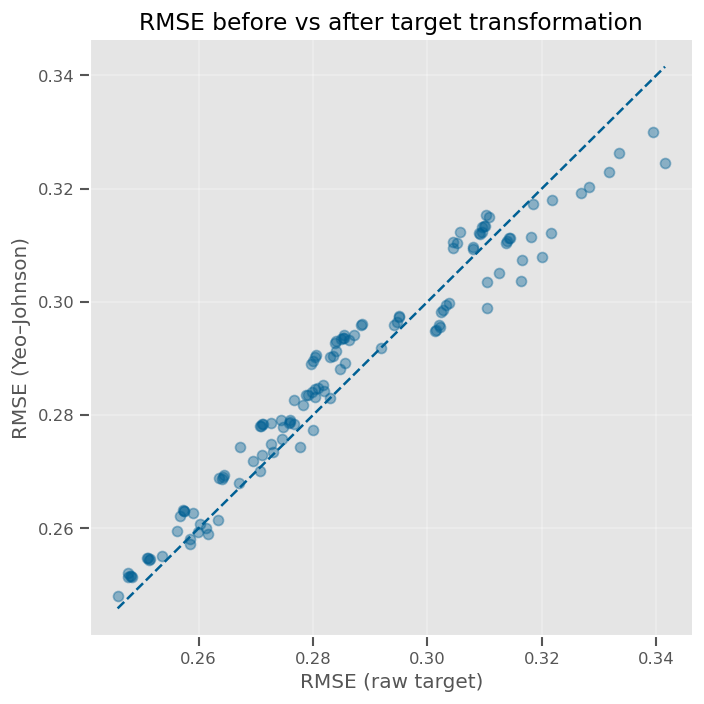

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(cmp["rmse_raw"], cmp["rmse_trans"], alpha=0.4)
lims = [
    min(cmp["rmse_raw"].min(), cmp["rmse_trans"].min()),
    max(cmp["rmse_raw"].max(), cmp["rmse_trans"].max()),
]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("RMSE (raw target)")
plt.ylabel("RMSE (Yeo–Johnson)")
plt.title("RMSE before vs after target transformation")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [102]:
import pandas as pd

h = 1
m1 = "CatBoost"
m2 = "Ridge"

df_cmp = (
    cmp[cmp["horizon"] == h]
    .pivot_table(
        index="train_end",
        columns="model",
        values="rmse_raw",   # or rmse_trans
    )
    .dropna()
)

df_cmp[[m1, m2]].head()


model,CatBoost,Ridge
train_end,,
2018-12-01,0.308057,0.305720
2019-12-01,0.310465,0.302110
2020-12-01,0.285532,0.294962
2021-12-01,0.274544,0.285486
2022-12-01,0.258464,0.251186


In [103]:
from scipy.stats import wilcoxon

diff = df_cmp[m1] - df_cmp[m2]

stat, pval = wilcoxon(diff)

stat, pval


(np.float64(9.0), np.float64(0.84375))

In [134]:
import pandas as pd
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

def build_state_series(y_m, meta_m, date_col="Date", state_col="State"):
    df = meta_m[[date_col, state_col]].copy()
    df["y"] = y_m.values
    df[date_col] = pd.to_datetime(df[date_col])

    state_series = {}

    for state, g in df.groupby(state_col):
        # Ensure we normalize dates to the start of the month immediately
        g[date_col] = g[date_col].dt.to_period("M").dt.to_timestamp()
        
        s = g.groupby(date_col)["y"].mean().sort_index()

        # Enforce regular MS grid
        full_idx = pd.date_range(s.index.min(), s.index.max(), freq="MS")
        s = s.reindex(full_idx)

        if s.isna().any():
            s = s.interpolate(limit_direction="both")

        s = s.asfreq("MS")
        state_series[state] = s

    return state_series


def ets_panel_rolling_origin(
    state_series: dict,
    splits_origins: list[dict],
    meta_m: pd.DataFrame,
    horizons=(1, 3, 6),
    seasonal_periods=12,
    model_name="ETS(A,A,A)",
):
    rows = []
    meta_dates = pd.to_datetime(meta_m["Date"])

    for split in splits_origins:
        train_end = pd.to_datetime(split["train_end"])

        # FIX: Change to_timestamp("M") to to_timestamp() for Month Start alignment
        test_dates = (
            meta_dates.loc[split["test_mask"]]
            .dt.to_period("M")
            .dt.to_timestamp() # Defaults to 'S' (Start of period)
            .unique()
        )

        for state, series in state_series.items():
            for t in test_dates:
                # Check if the date exists in the series
                if t not in series.index:
                    continue

                # Use the date as the 'origin' for the forecast
                y_train = series.loc[:t]

                # ETS needs enough history (2 full cycles is a safe rule of thumb)
                if len(y_train.dropna()) < 2 * seasonal_periods:
                    continue

                try:
                    ets = ETSModel(
                        y_train,
                        error="add",
                        trend="add",
                        seasonal="add",
                        seasonal_periods=seasonal_periods,
                    )
                    fit = ets.fit(disp=False)
                except Exception:
                    continue

                for h in horizons:
                    # target_date will naturally land on Month Start because t is MS
                    target_date = t + pd.offsets.MonthBegin(h)

                    if target_date not in series.index:
                        continue
                    
                    if pd.isna(series.loc[target_date]):
                        continue

                    try:
                        # Forecast h steps ahead from origin t
                        yhat = float(fit.forecast(steps=h).iloc[-1])
                    except Exception:
                        continue

                    rows.append({
                        "State": state,
                        "Date": t,
                        "train_end": train_end,
                        "horizon": h,
                        "model": model_name,
                        "y_true": float(series.loc[target_date]),
                        "y_pred": yhat,
                    })

    return rows

In [135]:
state_series = build_state_series(y_m=y_m, meta_m=meta_m)

state_series


{'ALABAMA': 2016-01-01    1.458312
 2016-02-01    0.854744
 2016-03-01    0.854186
 2016-04-01    1.052368
 2016-05-01    1.052737
                 ...   
 2024-08-01    1.276848
 2024-09-01    0.501253
 2024-10-01    1.047407
 2024-11-01    0.910291
 2024-12-01    0.727174
 Freq: MS, Name: y, Length: 108, dtype: float64,
 'ARKANSAS': 2016-01-01    1.387642
 2016-02-01    0.977278
 2016-03-01    0.976483
 2016-04-01    0.975927
 2016-05-01    0.568736
                 ...   
 2024-08-01    0.731261
 2024-09-01    0.584924
 2024-10-01    1.093932
 2024-11-01    0.727220
 2024-12-01    0.871333
 Freq: MS, Name: y, Length: 108, dtype: float64,
 'COLORADO': 2016-01-01    0.621094
 2016-02-01    0.813575
 2016-03-01    0.812631
 2016-04-01    0.694954
 2016-05-01    0.812191
                 ...   
 2024-08-01    0.639042
 2024-09-01    0.302358
 2024-10-01    0.268917
 2024-11-01    0.604900
 2024-12-01    0.671795
 Freq: MS, Name: y, Length: 108, dtype: float64,
 'CONNECTICUT': 2016-01-01

In [136]:
ets_rows = ets_panel_rolling_origin(
    state_series=state_series,
    splits_origins=splits_origins,
    meta_m=meta_m,
    horizons=[1, 3, 6],
)

In [137]:
ets_df = pd.DataFrame(ets_rows)
ets_df

,State,Date,train_end,horizon,model,y_true,y_pred
0,ALABAMA,2019-01-01,2018-12-01,1,"ETS(A,A,A)",1.209190,1.002433
1,ALABAMA,2019-01-01,2018-12-01,3,"ETS(A,A,A)",1.541574,1.100488
2,ALABAMA,2019-01-01,2018-12-01,6,"ETS(A,A,A)",1.201750,1.637629
3,ALABAMA,2019-02-01,2018-12-01,1,"ETS(A,A,A)",1.062597,1.144377
4,ALABAMA,2019-02-01,2018-12-01,3,"ETS(A,A,A)",1.299764,1.536744
...,...,...,...,...,...,...,...
6175,WISCONSIN,2024-08-01,2023-12-01,3,"ETS(A,A,A)",0.688954,0.587529
6176,WISCONSIN,2024-09-01,2023-12-01,1,"ETS(A,A,A)",0.787893,0.699214
6177,WISCONSIN,2024-09-01,2023-12-01,3,"ETS(A,A,A)",0.721880,0.540050
6178,WISCONSIN,2024-10-01,2023-12-01,1,"ETS(A,A,A)",0.688954,0.594386


In [138]:
ets_df["residual"] = ets_df["y_true"] - ets_df["y_pred"]

In [109]:
ets_df.head()

,State,Date,train_end,horizon,model,y_true,y_pred,residual
0,NATIONAL,2019-01-01,2018-12-01,1,"ETS(A,A,A)",0.923534,0.850627,0.072907
1,NATIONAL,2019-01-01,2018-12-01,3,"ETS(A,A,A)",0.814795,0.794162,0.020633
2,NATIONAL,2019-01-01,2018-12-01,6,"ETS(A,A,A)",0.942577,1.029762,-0.087184
3,NATIONAL,2019-02-01,2018-12-01,1,"ETS(A,A,A)",0.883729,0.839498,0.044231
4,NATIONAL,2019-02-01,2018-12-01,3,"ETS(A,A,A)",0.840194,0.838314,0.001880


In [139]:
metrics_ets = (
    ets_df
    .groupby(["train_end", "horizon", "model"])
    .apply(lambda d: pd.Series({
        "rmse": root_mean_squared_error(d["y_true"], d["y_pred"]),
        "mae": mean_absolute_error(d["y_true"], d["y_pred"]),
        "n_obs": len(d),
    }))
    .reset_index()
)

metrics_ets.head()

C:\Users\esper\AppData\Local\Temp\ipykernel_24620\2281791629.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,train_end,horizon,model,rmse,mae,n_obs
0,2018-12-01,1,"ETS(A,A,A)",0.345104,0.255555,360.0
1,2018-12-01,3,"ETS(A,A,A)",0.353114,0.251619,360.0
2,2018-12-01,6,"ETS(A,A,A)",0.367128,0.262453,360.0
3,2019-12-01,1,"ETS(A,A,A)",0.350300,0.250295,360.0
4,2019-12-01,3,"ETS(A,A,A)",0.366968,0.270525,360.0
